In [1]:
import base64
import copy 
import json
import os 
import tempfile
import time
import fitz  
from fpdf import FPDF
from IPython.display import Markdown, display
from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain_core.messages import HumanMessage
from langchain_experimental.text_splitter import SemanticChunker
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import FastEmbedSparse, QdrantVectorStore, RetrievalMode
from langchain_text_splitters import RecursiveCharacterTextSplitter
from mistralai import Mistral, DocumentURLChunk, ImageURLChunk, TextChunk
from mistralai.models import OCRResponse
from pathlib import Path
from pydantic import BaseModel
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import Distance, SparseVectorParams, VectorParams
from semantic_router.encoders import OpenAIEncoder
import concurrent.futures


/home/hashim/miniconda3/envs/mar/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
api_key = "" 
client = Mistral(api_key=api_key)

In [3]:
pdf_file = Path("/home/hashim/multimodal-agentic-rag/data/3. FYP-Handbook-2023.pdf")
assert pdf_file.is_file()

In [4]:
uploaded_file = client.files.upload(
    file={
        "file_name": pdf_file.stem,
        "content": pdf_file.read_bytes(),
    },
    purpose="ocr",
)

In [5]:
signed_url = client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)
print(f"Signed URL: {signed_url}")

Signed URL: url='https://mistralaifilesapiprodswe.blob.core.windows.net/fine-tune/097f57ac-bf45-431a-a1ea-aba2ecc0eee9/312c25307c3e427cbc8eb7b4c985aa24.pdf?se=2025-05-04T11%3A28%3A29Z&sp=r&sv=2025-05-05&sr=b&sig=m2%2BGdXB3F9gr4TCphQNZoGIPTR/BMpOk5S4Zi09e5OM%3D'


In [6]:
pdf_response = client.ocr.process(
    document=DocumentURLChunk(document_url=signed_url.url),
    model="mistral-ocr-latest",
    include_image_base64=True
)

In [7]:
response_dict = json.loads(pdf_response.model_dump_json())

{
    "pages": [
        {
            "index": 0,
            "markdown": "# BS FINAL YEAR PROJECT HANDBOOK 2023 (FAST SCHOOL OF COMPUTING) \n\nChiniot-Faisalabad-Islamabad-Karachi-Lahore-Peshawar www.nu.edu.pk",
            "images": [],
            "dimensions": {
                "dpi": 200,
                "height": 1800,
                "width": 1200
            }
        },
        {
            "index": 1,
            "markdown": "# NATIONAL UNIVERSITY of Computer and Emerging Sciences \n\n## BS FINAL YEAR PROJECT HANDBOOK 2023 <br> (FAST SCHOOL OF COMPUTING)\n\nRevised October 2023\n\n![img-0.jpeg](img-0.jpeg)\n\nRevised by:\nDr. Jawwad Ahmed Shamsi\nDr. Kashif Munir\n\nApproved by:\nDr. Aftab Ahmad Maroof\nDr. Waseem Ikram",
            "images": [
                {
                    "id": "img-0.jpeg",
                    "top_left_x": 477,
                    "top_left_y": 907,
                    "bottom_right_x": 716,
                    "bottom_right_y": 1146,
         
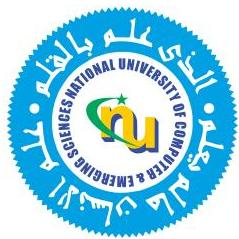
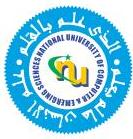
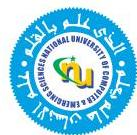
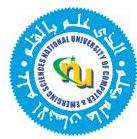
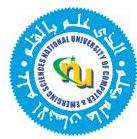
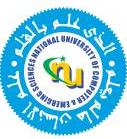
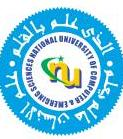
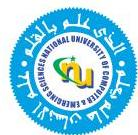
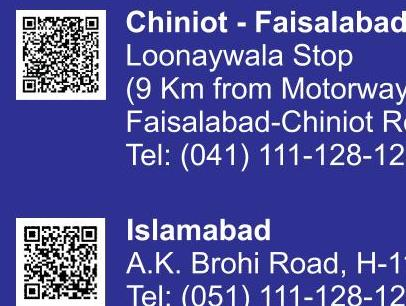

In [8]:
print(json.dumps(response_dict, indent=4)) 

In [9]:
with open("ocr_response.json", "w") as f:
    json.dump(response_dict, f, indent=4)

In [10]:
with open('/home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/ocr_response.json', 'r') as file:
    ocr_data = json.load(file)

all_images = {}

for page in ocr_data['pages']:
    if 'images' in page:
        for image in page['images']:
            image_id = image['id']
            image_base64 = image['image_base64']
            all_images[image_id] = image_base64

print(f"Total images extracted: {len(all_images)}")

Total images extracted: 9


{'img-0.jpeg': '',
 'img-1.jpeg': '',
 'img-2.jpeg': '',
 'img-3.jpeg': '',
 'img-4.jpeg': '',
 'img-5.jpeg': '',
 'img-6.jpeg': '',
 'img-7.jpeg': '',
 'img-8.jpeg': ''}
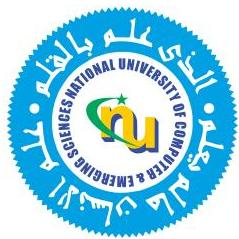
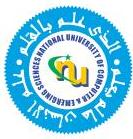
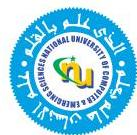
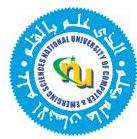
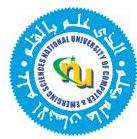
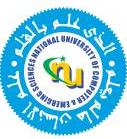
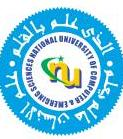
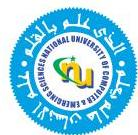
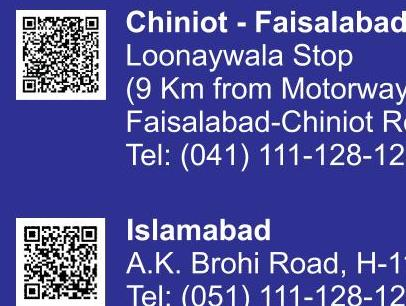

In [11]:
all_images

In [12]:
ocr_results = {}

for image_id, image_base64 in all_images.items():
    print(f"Processing image: {image_id}")
    time.sleep(3)  
    
    try:
        image_response = client.ocr.process(
            document=ImageURLChunk(image_url=image_base64),
            model="mistral-ocr-latest"
        )
        
        response_dict = json.loads(image_response.model_dump_json())
        ocr_results[image_id] = response_dict
        
    except Exception as e:
        print(f"Error processing image {image_id}: {str(e)}")

print(f"\nProcessed {len(ocr_results)} images out of {len(all_images)}")

with open("all_image_ocr_results.json", "w") as f:
    json.dump(ocr_results, f, indent=4)

if ocr_results:
    first_image_id = list(ocr_results.keys())[0]
    print(f"\nSample result for {first_image_id}:")
    print(json.dumps(ocr_results[first_image_id], indent=4))

Processing image: img-0.jpeg
Processing image: img-1.jpeg
Processing image: img-2.jpeg
Processing image: img-3.jpeg
Processing image: img-4.jpeg
Processing image: img-5.jpeg
Processing image: img-6.jpeg
Processing image: img-7.jpeg
Processing image: img-8.jpeg

Processed 9 images out of 9

Sample result for img-0.jpeg:
{
    "pages": [
        {
            "index": 0,
            "markdown": "![img-0.jpeg](img-0.jpeg)",
            "images": [
                {
                    "id": "img-0.jpeg",
                    "top_left_x": 0,
                    "top_left_y": 0,
                    "bottom_right_x": 238,
                    "bottom_right_y": 238,
                    "image_base64": null
                }
            ],
            "dimensions": {
                "dpi": 200,
                "height": 239,
                "width": 239
            }
        }
    ],
    "model": "mistral-ocr-2503-completion",
    "usage_info": {
        "pages_processed": 1,
        "doc_size_

In [13]:
ocr_results

{'img-0.jpeg': {'pages': [{'index': 0,
    'markdown': '![img-0.jpeg](img-0.jpeg)',
    'images': [{'id': 'img-0.jpeg',
      'top_left_x': 0,
      'top_left_y': 0,
      'bottom_right_x': 238,
      'bottom_right_y': 238,
      'image_base64': None}],
    'dimensions': {'dpi': 200, 'height': 239, 'width': 239}}],
  'model': 'mistral-ocr-2503-completion',
  'usage_info': {'pages_processed': 1, 'doc_size_bytes': 15932}},
 'img-1.jpeg': {'pages': [{'index': 0,
    'markdown': '\n',
    'images': [],
    'dimensions': {'dpi': 200, 'height': 139, 'width': 133}}],
  'model': 'mistral-ocr-2503-completion',
  'usage_info': {'pages_processed': 1, 'doc_size_bytes': 6850}},
 'img-2.jpeg': {'pages': [{'index': 0,
    'markdown': '\n',
    'images': [],
    'dimensions': {'dpi': 200, 'height': 135, 'width': 137}}],
  'model': 'mistral-ocr-2503-completion',
  'usage_info': {'pages_processed': 1, 'doc_size_bytes': 6990}},
 'img-3.jpeg': {'pages': [{'index': 0,
    'markdown': '\n',
    'images': []

In [14]:
class StructuredOCR(BaseModel):
    file_name: str
    topics: list[str]
    languages: str
    ocr_contents: dict

In [15]:
def structured_ocr_from_base64(image_id: str, base64_data: str) -> StructuredOCR:
    """
    Process a base64-encoded image using OCR and extract structured data.

    Args:
        image_id: Identifier for the image
        base64_data: Base64-encoded image data

    Returns:
        StructuredOCR object containing the extracted data
    """
    # Process the image using OCR
    image_response = client.ocr.process(
        document=ImageURLChunk(image_url=base64_data),
        model="mistral-ocr-latest"
    )
    image_ocr_markdown = image_response.pages[0].markdown

    # Parse the OCR result into a structured JSON response
    chat_response = client.chat.parse(
        model="pixtral-12b-latest",
        messages=[
            {
                "role": "user",
                "content": [
                    ImageURLChunk(image_url=base64_data),
                    TextChunk(text=(
                        f"This is the image's OCR in markdown:\n{image_ocr_markdown}\n.\n"
                        "Convert this into a structured JSON response "
                        "with the OCR contents in a sensible dictionary."
                    ))
                ]
            }
        ],
        response_format=StructuredOCR,
        temperature=0
    )

    return chat_response.choices[0].message.parsed

In [16]:
# Process all images in the all_images dictionary
structured_results = {}
total_images = len(all_images)

In [17]:

# Create a list to track skipped images
skipped_images = []

# Process all images with timeout handling
structured_results = {}
total_images = len(all_images)

# Create directory for images if it doesn't exist
image_dir = Path("processed_images")
image_dir.mkdir(exist_ok=True)

print(f"Starting to process {total_images} images...")

def save_base64_image(image_id, base64_data):
    """Decode base64 image data and save it to a file"""
    try:
        # Remove the base64 header if present
        if "," in base64_data:
            base64_data = base64_data.split(",", 1)[1]
        
        # Decode the base64 data
        image_data = base64.b64decode(base64_data)
        
        # Create a file path
        file_path = image_dir / f"{image_id}.jpg"
        
        # Write the image data to the file
        with open(file_path, "wb") as f:
            f.write(image_data)
        
        return str(file_path)
    except Exception as e:
        print(f"Error saving image {image_id}: {str(e)}")
        return None

def process_with_timeout(image_id, base64_data):
    """Process a single image with the structured OCR function"""
    return structured_ocr_from_base64(image_id, base64_data)

def save_progress():
    """Save current progress to JSON files"""
    with open("structured_ocr_results.json", "w") as f:
        json.dump(structured_results, f, indent=4)
    
    with open("skipped_images.json", "w") as f:
        json.dump(skipped_images, f, indent=4)
    
    print(f"Progress saved: {len(structured_results)}/{total_images} images processed")

# Set up the executor
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    for i, (image_id, base64_data) in enumerate(all_images.items(), 1):
        print(f"Processing image {i}/{total_images}: {image_id}")
        
        # Save the image to disk
        image_path = save_base64_image(image_id, base64_data)
        if image_path:
            print(f"Saved image to {image_path}")
        
        time.sleep(3)  # Rate limiting
        
        try:
            # Submit task with timeout
            future = executor.submit(process_with_timeout, image_id, base64_data)
            
            # Wait for result with timeout
            try:
                result = future.result(timeout=20)  # 20 second timeout
                
                # Store the result
                result_dict = json.loads(result.model_dump_json())
                # Add the image file path to the result
                if image_path:
                    result_dict["image_path"] = image_path
                structured_results[image_id] = result_dict
                print(f"Successfully processed {image_id}")
                
            except concurrent.futures.TimeoutError:
                # Handle timeout - cancel the future and track skipped image
                future.cancel()
                skipped_images.append({"index": i, "image_id": image_id, "image_path": image_path})
                print(f"TIMEOUT: Image {image_id} processing timed out after 20 seconds")
                structured_results[image_id] = {"error": "Processing timed out after 20 seconds", "image_path": image_path}
            
            # Save progress after each image is processed
            save_progress()
            
            # Add delay to avoid rate limiting
            time.sleep(2)
            
        except Exception as e:
            print(f"Error processing image {image_id}: {str(e)}")
            structured_results[image_id] = {"error": str(e), "image_path": image_path}
            skipped_images.append({"index": i, "image_id": image_id, "image_path": image_path})
            
            # Save progress after error
            save_progress()

# Final save to ensure all data is captured
save_progress()

print(f"\nProcessed {len(structured_results)} images. Results saved to 'structured_ocr_results.json'")
print(f"Skipped {len(skipped_images)} images. Details saved to 'skipped_images.json'")
print(f"Images saved to directory: {image_dir}")

Starting to process 9 images...
Processing image 1/9: img-0.jpeg
Saved image to processed_images/img-0.jpeg.jpg
Successfully processed img-0.jpeg
Progress saved: 1/9 images processed
Processing image 2/9: img-1.jpeg
Saved image to processed_images/img-1.jpeg.jpg
Error processing image img-1.jpeg: API error occurred: Status 429
{"message":"Requests rate limit exceeded"}
Progress saved: 2/9 images processed
Processing image 3/9: img-2.jpeg
Saved image to processed_images/img-2.jpeg.jpg
Successfully processed img-2.jpeg
Progress saved: 3/9 images processed
Processing image 4/9: img-3.jpeg
Saved image to processed_images/img-3.jpeg.jpg
Successfully processed img-3.jpeg
Progress saved: 4/9 images processed
Processing image 5/9: img-4.jpeg
Saved image to processed_images/img-4.jpeg.jpg
Successfully processed img-4.jpeg
Progress saved: 5/9 images processed
Processing image 6/9: img-5.jpeg
Saved image to processed_images/img-5.jpeg.jpg
Successfully processed img-5.jpeg
Progress saved: 6/9 imag

In [18]:
import json
import os

# --- Configuration ---
ocr_response_file = '/home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/ocr_response.json'
structured_results_file = '/home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/structured_ocr_results.json'
output_file = '/home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/merged_ocr_results.json'
# --- End Configuration ---

def merge_json_data(ocr_file, structured_file, output_file):
    """
    Merges structured OCR results into the original OCR response JSON.

    Args:
        ocr_file (str): Path to the ocr_response.json file.
        structured_file (str): Path to the structured_ocr_results.json file.
        output_file (str): Path to save the merged JSON file.
    """
    try:
        # Load the original OCR response
        with open(ocr_file, 'r') as f:
            ocr_data = json.load(f)

        # Load the structured OCR results
        with open(structured_file, 'r') as f:
            structured_data = json.load(f)

        # Ensure 'pages' key exists in ocr_data
        if 'pages' not in ocr_data or not isinstance(ocr_data['pages'], list):
            print(f"Error: 'pages' key not found or not a list in {ocr_file}")
            return

        # Process each page
        for page in ocr_data.get('pages', []):
            if 'images' in page:
                original_images = page['images']
                if not original_images:
                    # Case 1: Empty images list - remove the key
                    del page['images']
                else:
                    # Case 2: Non-empty images list - replace content
                    processed_images = []
                    for img_info in original_images:
                        img_id = img_info.get('id')
                        if img_id and img_id in structured_data:
                            structured_info = structured_data[img_id]
                            # Create a new dictionary with desired fields
                            new_img_entry = {
                                "id": img_id,
                                "topics": structured_info.get("topics", []), # Default to empty list if missing
                                "ocr_contents": structured_info.get("ocr_contents", {}) # Default to empty dict if missing
                            }
                            processed_images.append(new_img_entry)
                        else:
                            # Optional: Handle cases where ID is missing or not found
                            print(f"Warning: Image ID '{img_id}' not found in {structured_file} for page {page.get('index', 'N/A')}. Keeping original minimal info or skipping.")
                            # Decide whether to keep minimal original info or skip entirely
                            # Example: Keep only ID if needed
                            # processed_images.append({"id": img_id})
                            # Or simply skip by doing nothing here

                    # Replace the original 'images' list with the processed one
                    page['images'] = processed_images

        # Save the merged data
        output_dir = os.path.dirname(output_file)
        if output_dir and not os.path.exists(output_dir):
             os.makedirs(output_dir) # Create directory if it doesn't exist

        with open(output_file, 'w') as f:
            json.dump(ocr_data, f, indent=4)

        print(f"Successfully merged data and saved to {output_file}")

    except FileNotFoundError:
        print(f"Error: One or both input files not found.")
        print(f"  OCR Response File: {ocr_file}")
        print(f"  Structured Results File: {structured_file}")
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from one of the files. Details: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Run the merging process ---
merge_json_data(ocr_response_file, structured_results_file, output_file)

Successfully merged data and saved to /home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/merged_ocr_results.json


In [19]:
import json
import os

def format_ocr_contents(ocr_data):
    """Formats the OCR contents dictionary into a markdown-readable string."""
    lines = []
    if isinstance(ocr_data, dict):
        for category, details in ocr_data.items():
            # Add the main category (e.g., Department name or 'Total')
            lines.append(f"\n**{category}:**")
            if isinstance(details, dict):
                # Add the key-value pairs under the category
                for key, value in details.items():
                    # Use indentation for readability
                    lines.append(f"  - {key}: {value}")
            elif details is not None:
                 # Handle cases where the value isn't a dictionary but still needs printing
                 lines.append(f"  - Data: {details}")
            # else: skip if details are None or empty in a way not handled above
    else:
        # Fallback for unexpected data types
        lines.append(f"\nUnexpected OCR data format: {ocr_data}")
    return "\n".join(lines)

def convert_json_to_markdown(json_path, md_path):
    """
    Reads a JSON file, converts its content to Markdown format,
    and writes it to an output Markdown file. Handles image data specially.
    """
    try:
        with open(json_path, 'r', encoding='utf-8') as f_json:
            data = json.load(f_json)
    except FileNotFoundError:
        print(f"Error: JSON file not found at {json_path}")
        return
    except json.JSONDecodeError as e:
        print(f"Error: Could not decode JSON from {json_path}. Details: {e}")
        return
    except Exception as e:
        print(f"An unexpected error occurred while reading the JSON file: {e}")
        return

    markdown_output_parts = []

    if 'pages' not in data or not isinstance(data['pages'], list):
        print("Error: JSON structure invalid. Missing 'pages' list or it's not a list.")
        return

    # Optional: Sort pages by index if they might be out of order
    # pages = sorted(data['pages'], key=lambda p: p.get('index', 0))
    pages = data['pages'] # Assuming input JSON is already ordered by index

    for i, page in enumerate(pages):
        # Add page markdown content first
        if 'markdown' in page and isinstance(page['markdown'], str):
            markdown_output_parts.append(page['markdown'])
        else:
             markdown_output_parts.append(f"\n\n*-- Markdown content missing for page index {page.get('index', i)} --*\n\n")


        # Check for and process images on the page
        if 'images' in page and isinstance(page['images'], list) and page['images']:
            markdown_output_parts.append("\n") # Add space before image data
            for image in page['images']:
                image_id = image.get('id', 'Unknown_Image')
                markdown_output_parts.append(f"---") # Separator for image data
                markdown_output_parts.append(f"### Image Data: ({image_id})")

                # Format Topics
                if 'topics' in image and isinstance(image['topics'], list) and image['topics']:
                    markdown_output_parts.append("\n#### Topics:")
                    for topic in image['topics']:
                        markdown_output_parts.append(f"- {topic}")
                else:
                    markdown_output_parts.append("\n*No topics listed for this image.*")


                # Format OCR Contents
                if 'ocr_contents' in image and image['ocr_contents']:
                     markdown_output_parts.append("\n#### OCR Contents:")
                     formatted_ocr = format_ocr_contents(image['ocr_contents'])
                     markdown_output_parts.append(formatted_ocr)
                else:
                    markdown_output_parts.append("\n*No OCR content available for this image.*")

                markdown_output_parts.append(f"---") # Separator after image data

        # Add a clear separator between page contents in the final markdown
        # Avoid adding an extra separator if the last element was already one
        if not markdown_output_parts[-1].strip().endswith("---"):
             markdown_output_parts.append("\n\n---\n\n")


    # Write the combined markdown content to the output file
    try:
        with open(md_path, 'w', encoding='utf-8') as f_md:
            # Join parts with double newlines for paragraph spacing,
            # but handle existing separators correctly.
            full_markdown = "".join(markdown_output_parts)
            f_md.write(full_markdown)
        print(f"Successfully converted JSON to Markdown: {md_path}")
    except IOError as e:
        print(f"Error: Could not write Markdown file to {md_path}. Details: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while writing the Markdown file: {e}")


# --- Main Execution ---
if __name__ == "__main__":
    # --- Configuration ---
    # Make sure to replace 'your_input_file.json' with the actual path to your JSON
    input_json_file = '/home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/merged_ocr_results.json'
    # Replace 'output_report.md' with your desired output Markdown file name
    output_markdown_file = '/home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/merged_markdown.md'
    # --- End Configuration ---

    if not os.path.exists(input_json_file):
         print(f"Error: Input JSON file '{input_json_file}' does not exist in the current directory.")
         print("Please make sure the file path is correct.")
    else:
        convert_json_to_markdown(input_json_file, output_markdown_file)

Successfully converted JSON to Markdown: /home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/merged_markdown.md


In [20]:
# write code that replaces $\\checkmark$ with Yes. It will take a markdown file as input and output a new markdown file with the replacements made.
def replace_checkmark_with_yes(input_file, output_file):
    """
    Replaces all occurrences of $\\checkmark$ with 'Yes' in a markdown file.

    Args:
        input_file (str): Path to the input markdown file.
        output_file (str): Path to save the modified markdown file.
    """
    try:
        with open(input_file, 'r', encoding='utf-8') as f:
            content = f.read()

        # Replace $\\checkmark$ with 'Yes'
        modified_content = content.replace("$\\checkmark$", "Yes")

        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(modified_content)

        print(f"Successfully replaced checkmarks and saved to {output_file}")

    except FileNotFoundError:
        print(f"Error: Input file '{input_file}' not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        
# --- Main Execution ---
if __name__ == "__main__":
    # --- Configuration ---
    input_markdown_file = '/home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/merged_markdown.md'
    output_markdown_file = '/home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/merged_markdown_yes.md'
    # --- End Configuration ---

    replace_checkmark_with_yes(input_markdown_file, output_markdown_file)

Successfully replaced checkmarks and saved to /home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/merged_markdown_yes.md


In [2]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_core.documents import Document

In [3]:
markdown_path = "/home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/merged_markdown_yes.md"
loader = UnstructuredMarkdownLoader(markdown_path)

In [4]:
docs = loader.load()

In [5]:
docs

[Document(metadata={'source': '/home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/merged_markdown_yes.md'}, page_content='BS FINAL YEAR PROJECT HANDBOOK 2023 (FAST SCHOOL OF COMPUTING)\n\nChiniot-Faisalabad-Islamabad-Karachi-Lahore-Peshawar www.nu.edu.pk\n\nNATIONAL UNIVERSITY of Computer and Emerging Sciences\n\nBS FINAL YEAR PROJECT HANDBOOK 2023 (FAST SCHOOL OF COMPUTING)\n\nRevised October 2023\n\nimg-0.jpeg\n\nRevised by: Dr. Jawwad Ahmed Shamsi Dr. Kashif Munir\n\nApproved by: Dr. Aftab Ahmad Maroof Dr. Waseem Ikram ---### Image Data: (img-0.jpeg)\n\nTopics:- National University of Computer and Emerging Sciences- NU\n\nOCR Contents:\n\ntext: - Data: NATIONAL UNIVERSITY OF COMPUTER AND EMERGING SCIENCES\n\narabic_text: - Data: جامعة العلوم والتكنولوجيا الوطنية---\n\nTable of Contents\n\nPreface ..... 02 Acknowledgments ..... 03\n\nGlossary ..... 04\n\nThe Role of FYP Coordinators ..... 05\n\nThe Role of a Supervisor ..... 12\n\nFinal Year Project Offering ..... 13\n\n

In [6]:
# read the markdown file
markdown_path = "/home/hashim/multimodal-agentic-rag/data_ingestion/fyp_handbook/merged_markdown_yes.md"
with open(markdown_path, 'r') as file:
    markdown_content = file.read()
    
markdown_content

'# BS FINAL YEAR PROJECT HANDBOOK 2023 (FAST SCHOOL OF COMPUTING) \n\nChiniot-Faisalabad-Islamabad-Karachi-Lahore-Peshawar www.nu.edu.pk\n\n---\n\n# NATIONAL UNIVERSITY of Computer and Emerging Sciences \n\n## BS FINAL YEAR PROJECT HANDBOOK 2023 <br> (FAST SCHOOL OF COMPUTING)\n\nRevised October 2023\n\n![img-0.jpeg](img-0.jpeg)\n\nRevised by:\nDr. Jawwad Ahmed Shamsi\nDr. Kashif Munir\n\nApproved by:\nDr. Aftab Ahmad Maroof\nDr. Waseem Ikram\n---### Image Data: (img-0.jpeg)\n#### Topics:- National University of Computer and Emerging Sciences- NU\n#### OCR Contents:\n**text:**\n  - Data: NATIONAL UNIVERSITY OF COMPUTER AND EMERGING SCIENCES\n\n**arabic_text:**\n  - Data: جامعة العلوم والتكنولوجيا الوطنية---\n\n\n---\n\n# Table of Contents \n\nPreface ..... 02\nAcknowledgments ..... 03\n\n1. Glossary ..... 04\n2. The Role of FYP Coordinators ..... 05\n3. The Role of a Supervisor ..... 12\n4. Final Year Project Offering ..... 13\n5. The Process ..... 14\n5.1 An Agile and Iterative FYP Pr

In [7]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

In [8]:
headers_to_split_on = [
    ("#", "Header 1"),
]

In [9]:
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on)
md_header_splits = markdown_splitter.split_text(markdown_content)
md_header_splits

[Document(metadata={'Header 1': 'BS FINAL YEAR PROJECT HANDBOOK 2023 (FAST SCHOOL OF COMPUTING)'}, page_content='Chiniot-Faisalabad-Islamabad-Karachi-Lahore-Peshawar www.nu.edu.pk  \n---'),
 Document(metadata={'Header 1': 'NATIONAL UNIVERSITY of Computer and Emerging Sciences'}, page_content='## BS FINAL YEAR PROJECT HANDBOOK 2023 <br> (FAST SCHOOL OF COMPUTING)  \nRevised October 2023  \n![img-0.jpeg](img-0.jpeg)  \nRevised by:\nDr. Jawwad Ahmed Shamsi\nDr. Kashif Munir  \nApproved by:\nDr. Aftab Ahmad Maroof\nDr. Waseem Ikram\n---### Image Data: (img-0.jpeg)\n#### Topics:- National University of Computer and Emerging Sciences- NU\n#### OCR Contents:\n**text:**\n- Data: NATIONAL UNIVERSITY OF COMPUTER AND EMERGING SCIENCES  \n**arabic_text:**\n- Data: جامعة العلوم والتكنولوجيا الوطنية---  \n---'),
 Document(metadata={'Header 1': 'Table of Contents'}, page_content='Preface ..... 02\nAcknowledgments ..... 03  \n1. Glossary ..... 04\n2. The Role of FYP Coordinators ..... 05\n3. The Role 

In [ ]:
QDRANT_CLOUD_MULTIMODAL_AGENTIC_RAG_URL=""
QDRANT_CLOUD_MULTIMODAL_AGENTIC_RAG_API_KEY=""

In [ ]:
os.environ["OPENAI_API_KEY"] = ""

In [13]:
dense_embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")

In [14]:
qdrant = QdrantVectorStore.from_documents(
    md_header_splits,
    dense_embeddings,
    sparse_embedding=sparse_embeddings,
    retrieval_mode=RetrievalMode.HYBRID,
    url=QDRANT_CLOUD_MULTIMODAL_AGENTIC_RAG_URL,
    prefer_grpc=True,
    api_key=QDRANT_CLOUD_MULTIMODAL_AGENTIC_RAG_API_KEY,
    collection_name="fyp_handbook_chunks",
)